In [3]:
# Requirements
# python=3.11.14
#pip install -r requirements.txt

In [4]:
# pip install rdkit
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, PandasTools
import seaborn as sns
import os
import random

# pandas is used to read/process data
import pandas as pd

# machine learning dependencies
# scaling of data
from sklearn.preprocessing import RobustScaler
# train/test split
from sklearn.model_selection import train_test_split
# model selection
from sklearn.model_selection import GridSearchCV
# linear model
from sklearn.linear_model import LinearRegression
# Dummy model as baseline
from sklearn.dummy import DummyRegressor
# metrics to measure model performance
from sklearn.metrics import (mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error)
# R2 score
from sklearn.metrics import r2_score

# save/load models
import joblib

# For the permutation importance implementation
from joblib import Parallel
from joblib import delayed

#XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV


#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from itertools import product

#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Permutation Importance
from sklearn.inspection import permutation_importance

# plotting
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
# Load the Data Frame from Github repository
df = pd.read_csv("https://raw.githubusercontent.com/GjotoGjoto/1147_new/refs/heads/main/dataset.csv", storage_options={"verify_ssl": False})

**EDA**

In [6]:
# Checking dimensions and first few rows
print(f"Dataet Shape: {df.shape}")
print("First few rows:")
df.head()

Dataet Shape: (7973, 7)
First few rows:


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [7]:
# Canonicalizing SMILES strings
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.MolToSmiles(mol)
    else:
        return None

# Apply the function to the SMILES column and create a new column with canonical SMILES
# If a SMILES string cannot be parsed, it will be set to None

df["canonical_smiles"] = df['SMILES'].apply(canonicalize_smiles)
changed = df[df["SMILES"] != df["canonical_smiles"]]
changed.head()
print(f"Total changed SMILES: {len(changed)}")



Total changed SMILES: 17


In [8]:
# Checking how many unique SMILES and canonical SMILES there are
unique_smiles = df["SMILES"].nunique()
unique_canonical_smiles = df["canonical_smiles"].nunique()
print(f"Unique SMILES: {unique_smiles}")
print(f"unique_canonical_smiles: {unique_canonical_smiles}")


Unique SMILES: 7973
unique_canonical_smiles: 7973


In [9]:
# Updating dataset with relevant descriptors
# Adding column called "molecule" with mol object
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="canonical_smiles", molCol="molecule")

# adding descriptors
def calculate_key_descriptors(mol):
     MW = Descriptors.MolWt(mol)
     LogP = Descriptors.MolLogP(mol)
     TPSA = Descriptors.TPSA(mol)
     HBD = Descriptors.NumHDonors(mol)
     HBA = Descriptors.NumHAcceptors(mol)
     RotBonds = Descriptors.NumRotatableBonds(mol)
     rings = Descriptors.RingCount(mol)
     FractionCSP3 = rdMolDescriptors.CalcFractionCSP3(mol)
     Labute_ASA = rdMolDescriptors.CalcLabuteASA(mol)
     MolMR = Descriptors.MolMR(mol)
     if mol:
        return MW, LogP, TPSA, HBD, HBA, RotBonds, rings, FractionCSP3, Labute_ASA, MolMR
     else:
        return None, None, None, None, None, None, None, None, None, None
df[['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds','rings', 'FractionCSP3', 'Labute_ASA', 'MolMR']] = df['molecule'].apply(lambda mol: pd.Series(calculate_key_descriptors(mol)))
df.head()
df.info()
    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7973 non-null   int64  
 1   SMILES            7973 non-null   object 
 2   Tg                511 non-null    float64
 3   FFV               7030 non-null   float64
 4   Tc                737 non-null    float64
 5   Density           613 non-null    float64
 6   Rg                614 non-null    float64
 7   canonical_smiles  7973 non-null   object 
 8   molecule          7973 non-null   object 
 9   MW                7973 non-null   float64
 10  LogP              7973 non-null   float64
 11  TPSA              7973 non-null   float64
 12  HBD               7973 non-null   float64
 13  HBA               7973 non-null   float64
 14  RotBonds          7973 non-null   float64
 15  rings             7973 non-null   float64
 16  FractionCSP3      7973 non-null   float64


In [10]:
# Performing data cleaning
# Dropping Tc, Density, Rg and Tg columns from neurips dataset that are not needed for our analysis
df = df.drop(columns=['Tc', 'Density', 'Rg', 'Tg'], errors='ignore')
# Dropping rows with null values
df.dropna(inplace=True)
# Dropping duplicate rows
df.drop_duplicates(inplace=True)
df.info()
# Reviewing statistics of the dataframe
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 0 to 7972
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7030 non-null   int64  
 1   SMILES            7030 non-null   object 
 2   FFV               7030 non-null   float64
 3   canonical_smiles  7030 non-null   object 
 4   molecule          7030 non-null   object 
 5   MW                7030 non-null   float64
 6   LogP              7030 non-null   float64
 7   TPSA              7030 non-null   float64
 8   HBD               7030 non-null   float64
 9   HBA               7030 non-null   float64
 10  RotBonds          7030 non-null   float64
 11  rings             7030 non-null   float64
 12  FractionCSP3      7030 non-null   float64
 13  Labute_ASA        7030 non-null   float64
 14  MolMR             7030 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 878.8+ KB


,id,FFV,MW,LogP,TPSA,HBD,HBA,RotBonds,rings,FractionCSP3,Labute_ASA,MolMR
count,7.030000e+03,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000
mean,1.078609e+09,0.367212,457.872328,5.737188,68.446939,0.905405,4.573826,8.846942,3.940114,0.314885,195.850928,127.535836
std,6.207845e+08,0.029609,241.639330,3.736482,47.210870,1.260725,2.908115,6.129783,3.083736,0.304052,102.796161,68.290252
min,8.781700e+04,0.226992,14.027000,-4.822900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.739251,4.807000
25%,5.436875e+08,0.349549,274.316000,3.118100,26.300000,0.000000,2.000000,5.000000,1.000000,0.052632,117.950467,75.811250
50%,1.076305e+09,0.364264,422.565000,5.208770,58.200000,0.000000,4.000000,7.000000,3.000000,0.230769,181.902795,119.552200
75%,1.621402e+09,0.380790,597.487500,7.692075,97.360000,2.000000,6.000000,11.000000,6.000000,0.482759,256.109705,166.695000
max,2.147438e+09,0.777097,2202.482000,27.557340,437.260000,8.000000,45.000000,92.000000,18.000000,1.000000,950.199587,615.918000


length of desc: 11


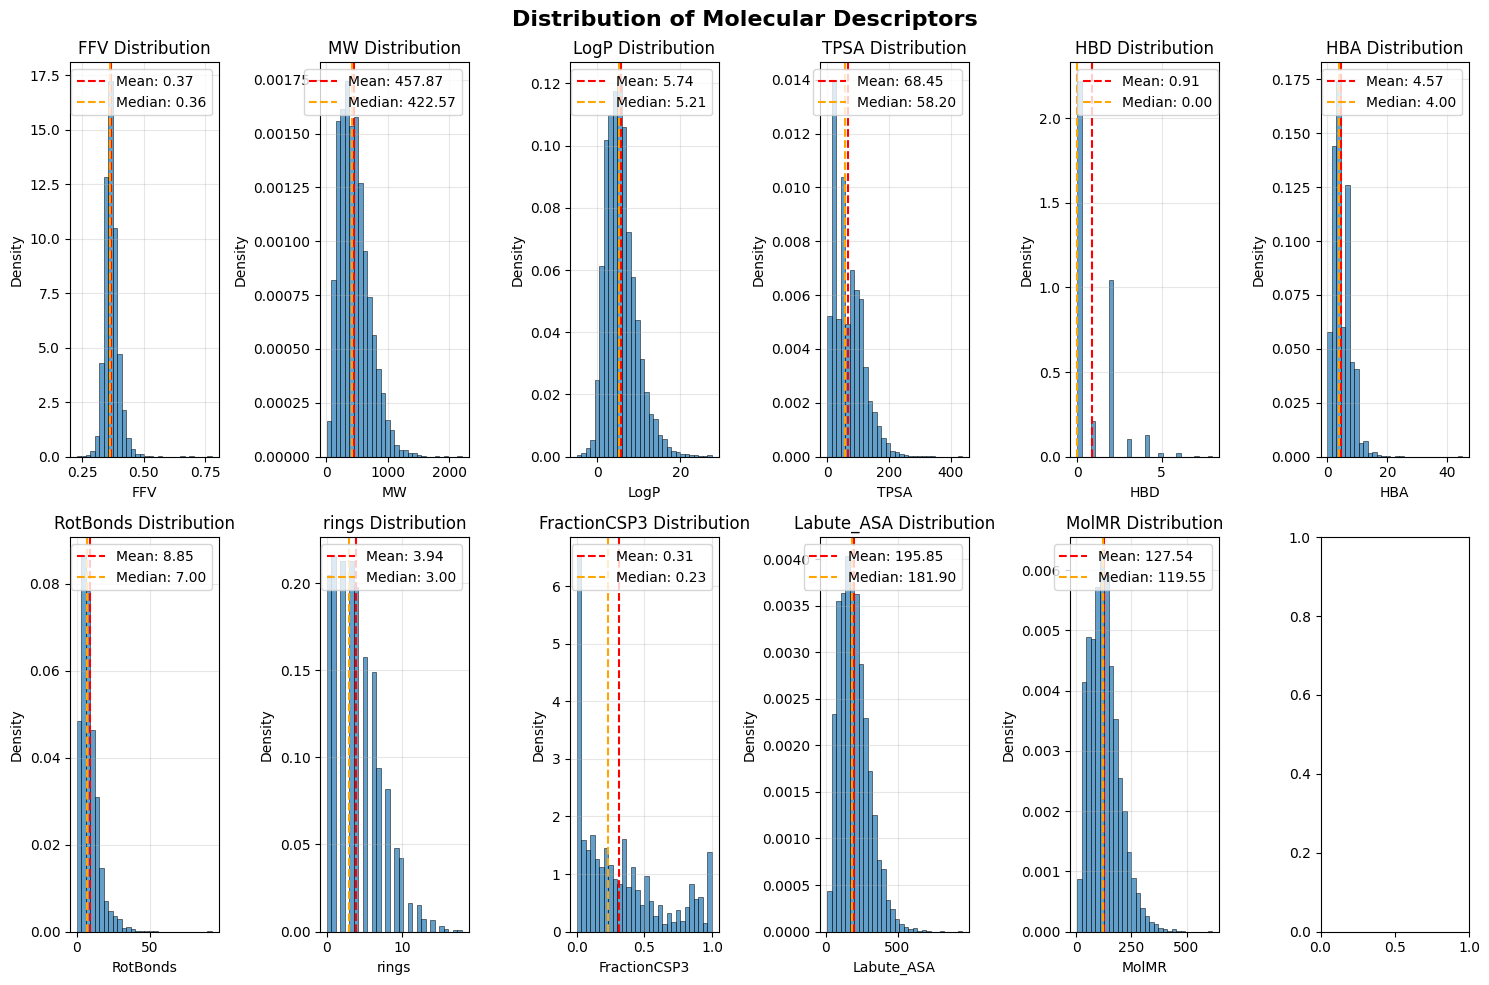

In [11]:
# Create visualized distribution for molecular descriptors

descriptors_to_plot = ['FFV', 'MW', 'LogP', 'TPSA', 'HBD', 'HBA','RotBonds', 'rings','FractionCSP3', 'Labute_ASA', 'MolMR']
for desc in descriptors_to_plot:
    if desc not in df.columns:
        print(f"Warning: Column '{desc}' not found in DataFrame. It will be skipped.")
descriptors_to_plot = [desc for desc in descriptors_to_plot if desc in df.columns]
print(f"length of desc: {len(descriptors_to_plot)}")
df_plot = df.dropna(subset=descriptors_to_plot)
# df.info()
fig, axes = plt.subplots(2, 6, figsize=(15, 10))
fig.suptitle('Distribution of Molecular Descriptors', fontsize=16, fontweight='bold')

for i, descriptor in enumerate(descriptors_to_plot):
    row = i // 6
    col = i % 6
    if row < 2 and col < 6:
        # Create histogram with density curve
        axes[row, col].hist(df_plot[descriptor], bins=30, alpha=0.7,
                           density=True, edgecolor='black', linewidth=0.5)

        # Add statistical information
        mean_val = df_plot[descriptor].mean()
        median_val = df_plot[descriptor].median()
        axes[row, col].axvline(mean_val, color='red', linestyle='--',
                              label=f'Mean: {mean_val:.2f}')
        axes[row, col].axvline(median_val, color='orange', linestyle='--',
                              label=f'Median: {median_val:.2f}')

        axes[row, col].set_title(f'{descriptor} Distribution')
        axes[row, col].set_xlabel(descriptor)
        axes[row, col].set_ylabel('Density')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/descriptors_histograms.png', dpi=600)
plt.show()


Correlation Matrix for Molecular Descriptors:
                FFV     MW   LogP   TPSA    HBD    HBA  RotBonds  rings  \
FFV           1.000  0.162  0.305 -0.216 -0.331 -0.148    -0.026  0.232   
MW            0.162  1.000  0.839  0.672  0.024  0.690     0.575  0.829   
LogP          0.305  0.839  1.000  0.255 -0.036  0.321     0.517  0.756   
TPSA         -0.216  0.672  0.255  1.000  0.261  0.915     0.443  0.482   
HBD          -0.331  0.024 -0.036  0.261  1.000  0.039    -0.012  0.064   
HBA          -0.148  0.690  0.321  0.915  0.039  1.000     0.543  0.468   
RotBonds     -0.026  0.575  0.517  0.443 -0.012  0.543     1.000  0.149   
rings         0.232  0.829  0.756  0.482  0.064  0.468     0.149  1.000   
FractionCSP3 -0.075 -0.425 -0.377 -0.292 -0.179 -0.253     0.164 -0.655   
Labute_ASA    0.176  0.992  0.863  0.654  0.043  0.670     0.575  0.859   
MolMR         0.213  0.968  0.887  0.603  0.079  0.622     0.569  0.872   

              FractionCSP3  Labute_ASA  MolMR  
FFV  

/Users/ghazalshafiee/Documents/CHE1147_project/myenv/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


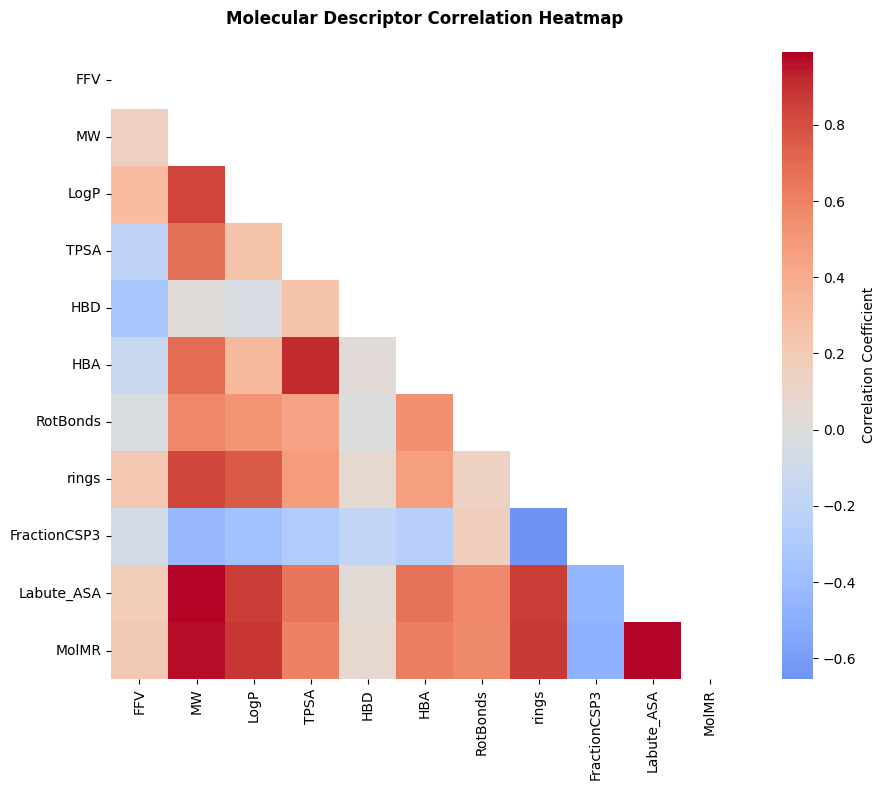

In [15]:
# HEATMAP
# Calculate correlation matrix for molecular descriptors
descriptor_cols = ['FFV', 'MW', 'LogP', 'TPSA', 'HBD', 'HBA','RotBonds', 'rings','FractionCSP3', 'Labute_ASA', 'MolMR']

# Calculate correlation matrix using .corr()
correlation_matrix = df[descriptor_cols].corr()

# Display correlation matrix
print("Correlation Matrix for Molecular Descriptors:")
print(correlation_matrix.round(3))

# Create correlation heatmap
plt.figure(figsize=(10, 8))

# Use seaborn for a more informative heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Molecular Descriptor Correlation Heatmap', fontweight='bold', pad=20)
plt.tight_layout()
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/descriptors_heatmap.png', dpi=1200)
plt.show()


/Users/ghazalshafiee/Documents/CHE1147_project/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ghazalshafiee/Documents/CHE1147_project/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ghazalshafiee/Documents/CHE1147_project/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ghazalshafiee/Documents/CHE1147_project/myenv/lib/python3.11/site-packages/sea

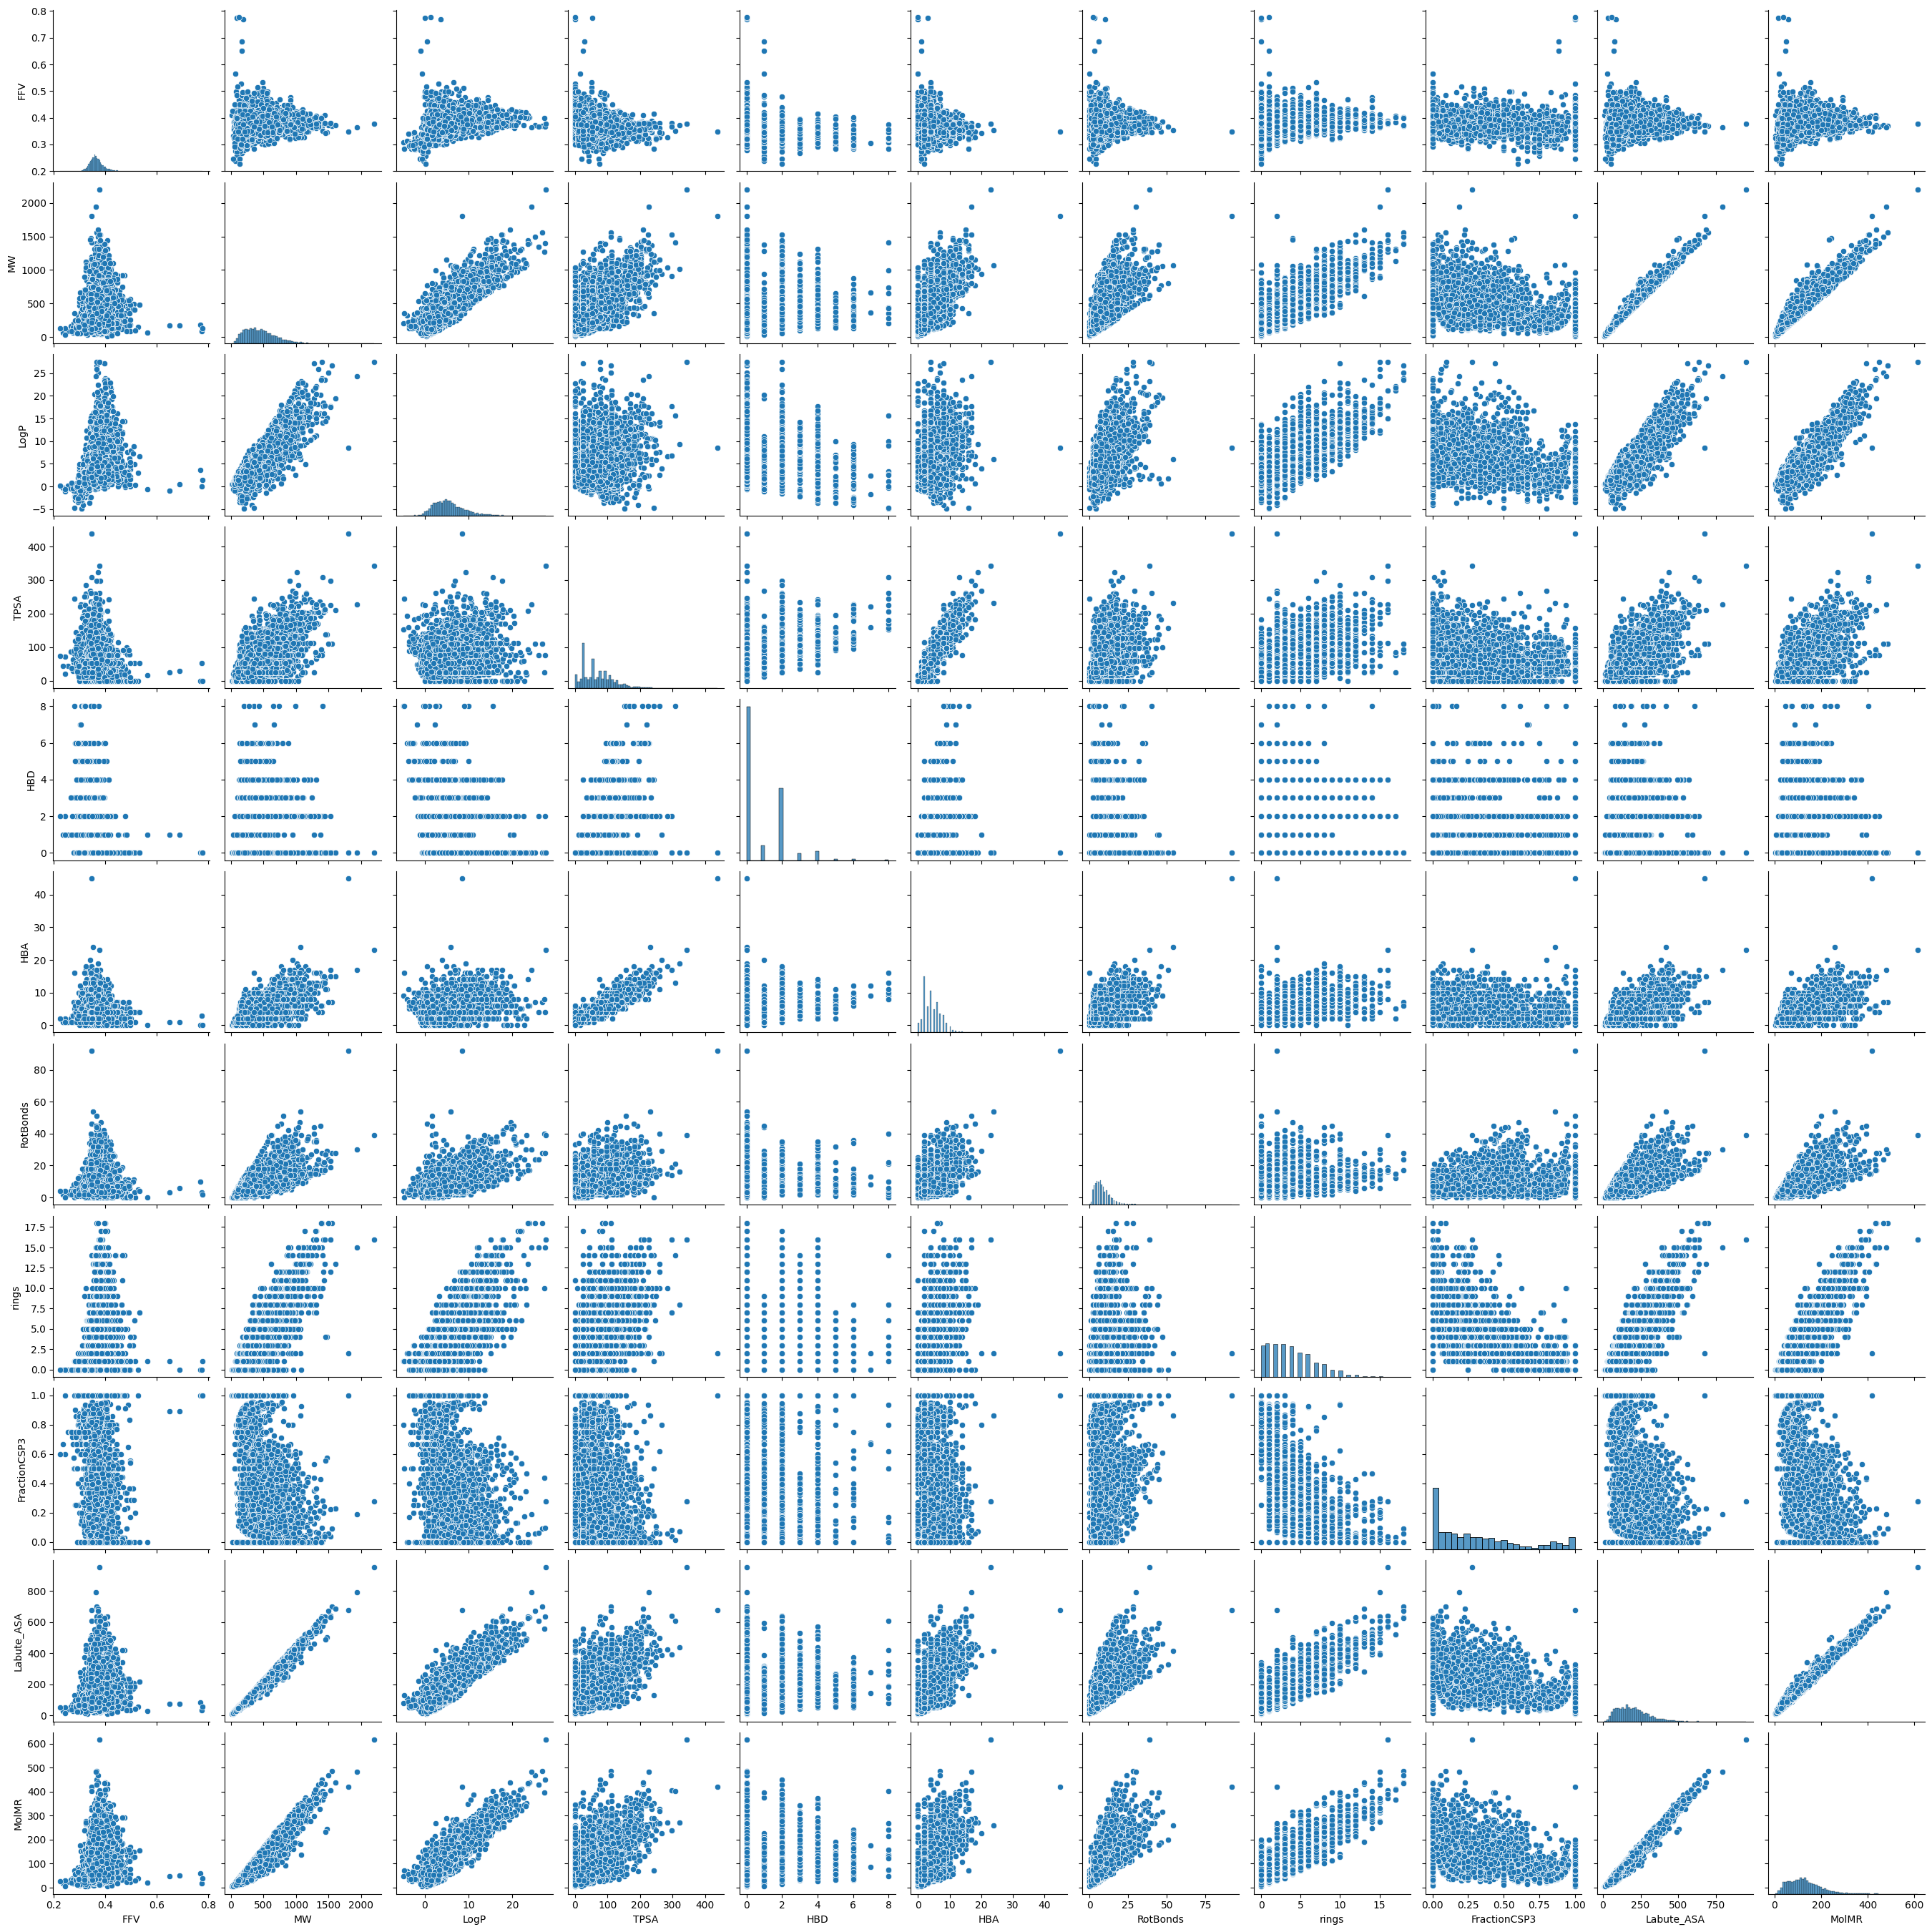

In [18]:
# Pairplot for all descriptors
sns.pairplot(df[descriptor_cols])
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/descriptors_pairplot.png', dpi=600)

In [19]:
# Dropping Labute_ASA, HBA, HBD columns after EDA
df = df.drop(columns=['Labute_ASA', 'HBA', 'HBD'], errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 0 to 7972
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7030 non-null   int64  
 1   SMILES            7030 non-null   object 
 2   FFV               7030 non-null   float64
 3   canonical_smiles  7030 non-null   object 
 4   molecule          7030 non-null   object 
 5   MW                7030 non-null   float64
 6   LogP              7030 non-null   float64
 7   TPSA              7030 non-null   float64
 8   RotBonds          7030 non-null   float64
 9   rings             7030 non-null   float64
 10  FractionCSP3      7030 non-null   float64
 11  MolMR             7030 non-null   float64
dtypes: float64(8), int64(1), object(3)
memory usage: 714.0+ KB


In [20]:
# Checking rows with TPSA = 0 to check the validity of these rows in terms of physical meaning
df[df['TPSA']==0]

,id,SMILES,FFV,canonical_smiles,molecule,MW,LogP,TPSA,RotBonds,rings,FractionCSP3,MolMR
35,8689461,*CC(*)CCCCCCCCCCCCCCCC,0.407873,*CC(*)CCCCCCCCCCCCCCCC,<rdkit.Chem.rdchem.Mol object at 0x139231e70>,252.486,7.1632,0.0,16.0,0.0,1.000000,83.486
41,10557152,*C(C)=C(*)[Ge](C)(C)C,0.399961,*C(C)=[C](*)[Ge]([CH3])([CH3])[CH3],<rdkit.Chem.rdchem.Mol object at 0x139232110>,156.772,2.1939,0.0,1.0,0.0,0.666667,36.046
138,41386383,*CCCCCC(*)CCCCCC,0.406286,*CCCCCC(*)CCCCCC,<rdkit.Chem.rdchem.Mol object at 0x139234c10>,168.324,4.8226,0.0,10.0,0.0,1.000000,55.784
147,44332410,*CC(*)CCCCCCC,0.405013,*CC(*)CCCCCCC,<rdkit.Chem.rdchem.Mol object at 0x139235000>,126.243,3.6523,0.0,7.0,0.0,1.000000,41.933
183,54206705,*C=C(*)C(CCCCCCC)[Si](C)(C)C,0.410606,*C=C(*)C(CCCCCCC)[Si](C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x139235fc0>,210.437,4.9953,0.0,8.0,0.0,0.846154,68.555
...,...,...,...,...,...,...,...,...,...,...,...,...
7806,2103439506,*CCC[Si](*)(C)C[Si](C)(C)C,0.405079,*CCC[Si](*)(C)C[Si](C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x16bc0c3c0>,172.420,3.3461,0.0,5.0,0.0,1.000000,54.002
7807,2103456476,*CC(*)c1ccc(CCCCCCCCC)cc1,0.399551,*CC(*)c1ccc(CCCCCCCCC)cc1,<rdkit.Chem.rdchem.Mol object at 0x16bc0c430>,230.395,5.5377,0.0,10.0,1.0,0.647059,75.687
7834,2111187299,*C(=Cc1ccc(C=C(c2ccccc2)c2ccc(-c3ccc(*)cc3)cc2...,0.397152,*C(=Cc1ccc(C=C(c2ccccc2)c2ccc(-c3ccc(*)cc3)cc2...,<rdkit.Chem.rdchem.Mol object at 0x16bc0d000>,432.566,8.1645,0.0,6.0,5.0,0.000000,145.682
7900,2127356325,*c1cc(CCCCCCCCCCCC)c(*)s1,0.410225,*c1cc(CCCCCCCCCCCC)c(*)s1,<rdkit.Chem.rdchem.Mol object at 0x16bc0ece0>,250.451,4.5607,0.0,11.0,1.0,0.750000,79.135


In [21]:
# Calculating properties of a given structure to compare to confirm the dataset accuracy 
# id 8689461 with TPSA = 0

mol = Chem.MolFromSmiles("*CC(*)CCCCCCCCCCCCCCCC")  # Example molecule
print("TPSA:", rdMolDescriptors.CalcTPSA(mol))
print("Rings:", mol.GetRingInfo().NumRings())
print("FractionCSP3:", rdMolDescriptors.CalcFractionCSP3(mol))


#id 10557152 with TPSA = 0

mol = Chem.MolFromSmiles("*C(C)=[C](*)[Ge]([CH3])([CH3])[CH3]")  # Example molecule
print("TPSA:", rdMolDescriptors.CalcTPSA(mol))
print("Rings:", mol.GetRingInfo().NumRings())
print("FractionCSP3:", rdMolDescriptors.CalcFractionCSP3(mol))


TPSA: 0.0
Rings: 0
FractionCSP3: 1.0
TPSA: 0.0
Rings: 0
FractionCSP3: 0.6666666666666666


**Data Splitting**

In [22]:
# Setting random seed for reproducibility
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)

In [23]:
# Splitting the dataset into training, testing, and validation sets
descriptor_features= ['MW', 'LogP', 'TPSA', 'RotBonds', 'rings','FractionCSP3', 'MolMR']
x = df[descriptor_features]
y = df['FFV']

x_train, x_test, y_train, y_test= train_test_split(
    x, y, 
    test_size=0.3,  # 30% of data (will later become 15% test + 15% validation)
    random_state=RANDOM_SEED  # Ensure reproducibility
)
x_test, x_validation, y_test, y_validation = train_test_split(
    x_test, y_test,
    test_size=0.5,  # split 30% in half -> 15% val, 15% test
    random_state=RANDOM_SEED  # Ensure reproducibility
)

In [24]:
# Display the shape of all sets
print(f"Descriptors features Training set size: {x_train.shape}")
print(f"Descriptors features Validation set size: {x_validation.shape}")
print(f"Descriptors featres Test set size: {x_test.shape}")
print(f"FFV Training set size: {y_train.shape}")
print(f"FFV Validation set size: {y_validation.shape}")
print(f"FFV Test set size: {y_test.shape}")

Descriptors features Training set size: (4921, 7)
Descriptors features Validation set size: (1055, 7)
Descriptors featres Test set size: (1054, 7)
FFV Training set size: (4921,)
FFV Validation set size: (1055,)
FFV Test set size: (1054,)


In [25]:
# Initializing the RobustScaler
scaler = RobustScaler()

# Fitting the scaler on training data only and transforming training, validation, and test sets
df_train_scaled = scaler.fit_transform(x_train)
df_validation_scaled = scaler.transform(x_validation)
df_test_scaled = scaler.transform(x_test)

In [26]:
# Pearson and Spearman Correlation calculation
df_subsets = pd.concat([x_train, y_train], axis=1)
y_train = pd.Series(y_train, name='FFV')
pearson_corr = df_subsets.corr(method='pearson')['FFV']
sorted_pearson_corr = pearson_corr.sort_values(ascending=False)
print("Pearson Correlation with FFV:")
print(sorted_pearson_corr)
print("\n")

spearman_corr = df_subsets.corr(method='spearman')['FFV']
sorted_spearman_corr = spearman_corr.sort_values(ascending=False)
print("Spearman Correlation with FFV:")
print(sorted_spearman_corr)

Pearson Correlation with FFV:
FFV             1.000000
LogP            0.296367
rings           0.224695
MolMR           0.202839
MW              0.150729
RotBonds       -0.039736
FractionCSP3   -0.057315
TPSA           -0.225353
Name: FFV, dtype: float64


Spearman Correlation with FFV:
FFV             1.000000
LogP            0.378120
rings           0.293112
MolMR           0.270187
MW              0.214005
RotBonds       -0.048973
FractionCSP3   -0.107520
TPSA           -0.237531
Name: FFV, dtype: float64


**Dummy Regressor**

In [27]:
# Build DummyRegressors
dummyregressor_mean = DummyRegressor(strategy='mean')
dummyregressor_median = DummyRegressor(strategy='median')

In [28]:
# Fit Dummy Regressors
dummyregressor_mean.fit(x_train, y_train)
dummyregressor_median.fit(x_train, y_train)

,strategy,'median'
,constant,None
,quantile,None


In [29]:
# Defining function to determine regression metrics
def get_regression_metrics(model, X, y_true):
    """
    Get a dicionary with regression metrics:

    model: sklearn model with predict method
    X: feature matrix
    y_true: ground truth labels
    """
    y_predicted = model.predict(X)
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    maximum_error = max_error(y_true, y_predicted)
    mape =  mean_absolute_percentage_error(y_true, y_predicted)
    r2 = r2_score(y_true, y_predicted)
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))


    metrics_dict = {
        'mae': mae,
        'mse': mse,
        'max_error': maximum_error,
        'mape': mape,
        'r2': r2,
        'rmse': rmse
    }

    return metrics_dict
    y_predicted.shape()


In [30]:
# Dictionaries to store results
dummy_regressors = [
    ('mean', dummyregressor_mean),
    ('median', dummyregressor_median)
]

In [31]:
# Calculating metrics for dummy regressors
dummy_regressor_results_test = {} # initialize empty dictionary
dummy_regressor_results_train = {}

# loop over the dummy_regressor list
# if you have a tuple regressorname, regressor = (a, b) that is automatically expanded into the variables
# a = regressorname, b = regressor
for regressorname, regressor in dummy_regressors:
    print(f"Calculating metrics for {regressorname}")
    dummy_regressor_results_test[regressorname] = get_regression_metrics(regressor, x_test, y_test)
    dummy_regressor_results_train[regressorname] = get_regression_metrics(regressor, x_train, y_train)

Calculating metrics for mean
Calculating metrics for median


In [32]:
# Final predictions using median dummy regressor
test = dummyregressor_median.predict(x_test)

In [33]:
# Printing results of dummy regressors
print("Dummy Regressor Results - Train & Test Set")

for regressorname, metrics in dummy_regressor_results_train.items():
    print(f"{regressorname} (Train): {metrics}")

for regressorname, metrics in dummy_regressor_results_test.items():
    print(f"{regressorname} (Test): {metrics}")


Dummy Regressor Results - Train & Test Set
mean (Train): {'mae': 0.021014877759118766, 'mse': 0.0009103925676446638, 'max_error': 0.4097815546006909, 'mape': 0.05664376975814881, 'r2': 0.0, 'rmse': np.float64(0.030172712301758088)}
median (Train): {'mae': 0.02084595620808779, 'mse': 0.0009196393083871628, 'max_error': 0.4128223999999999, 'mape': 0.055716182114853775, 'r2': -0.010156871959556835, 'rmse': np.float64(0.030325555368157113)}
mean (Test): {'mae': 0.020829248435589715, 'mse': 0.0008081703970908331, 'max_error': 0.1466664246006909, 'mape': 0.05698848180504437, 'r2': -0.0016549666642686756, 'rmse': np.float64(0.02842833792346702)}
median (Test): {'mae': 0.020605761992409866, 'mse': 0.0008103894678955665, 'max_error': 0.14970726999999995, 'mape': 0.05590958375448009, 'r2': -0.004405306568999512, 'rmse': np.float64(0.02846734037270722)}


**Linear Regression**

In [34]:
#Initializing Linear Regression Model

linear_regressor = LinearRegression()

#Train the model on the training set
linear_regressor.fit(x_train, y_train)

#Evaluate the model on training and validation sets
linear_regressor_results_train = get_regression_metrics(linear_regressor, x_train, y_train)
linear_regressor_results_validation = get_regression_metrics(linear_regressor, x_validation, y_validation)
#Printing the results
print("Linear Regression Results - Train Set", linear_regressor_results_train)
print("Linear Regression Results - Validation Set", linear_regressor_results_validation)

Linear Regression Results - Train Set {'mae': 0.01708354130138917, 'mse': 0.0006566627332577289, 'max_error': 0.42213204051806086, 'mape': 0.045827393834941416, 'r2': 0.27870376297488453, 'rmse': np.float64(0.025625431377007662)}
Linear Regression Results - Validation Set {'mae': 0.017300515590971954, 'mse': 0.0005701591265470737, 'max_error': 0.14630930682565346, 'mape': 0.04643271363889049, 'r2': 0.275433714748609, 'rmse': np.float64(0.023878005078881145)}


In [35]:
# Comparing results of LR with dummy regressor
print("Dummy Regression Results:", dummy_regressor_results_test)
print("Linear Regression Results on train set:", linear_regressor_results_train)
print("Linear Regression Results on validation set:", linear_regressor_results_validation)

Dummy Regression Results: {'mean': {'mae': 0.020829248435589715, 'mse': 0.0008081703970908331, 'max_error': 0.1466664246006909, 'mape': 0.05698848180504437, 'r2': -0.0016549666642686756, 'rmse': np.float64(0.02842833792346702)}, 'median': {'mae': 0.020605761992409866, 'mse': 0.0008103894678955665, 'max_error': 0.14970726999999995, 'mape': 0.05590958375448009, 'r2': -0.004405306568999512, 'rmse': np.float64(0.02846734037270722)}}
Linear Regression Results on train set: {'mae': 0.01708354130138917, 'mse': 0.0006566627332577289, 'max_error': 0.42213204051806086, 'mape': 0.045827393834941416, 'r2': 0.27870376297488453, 'rmse': np.float64(0.025625431377007662)}
Linear Regression Results on validation set: {'mae': 0.017300515590971954, 'mse': 0.0005701591265470737, 'max_error': 0.14630930682565346, 'mape': 0.04643271363889049, 'r2': 0.275433714748609, 'rmse': np.float64(0.023878005078881145)}


**XGBoost**

In [36]:
# XGBoost Regressor
# Combine train and validation for cross-validation
X_train_full = pd.concat([x_train, x_validation], axis=0)
y_train_full = pd.concat([y_train, y_validation], axis=0)
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full)

# Setting up hyperparameter ranges for tuning
parameter_range = {
    'max_depth': [4, 6, 8],         #to control depth at which each decision tree can grow
    'eta': [0.01, 0.05, 0.1],       #learning rate
    'subsample': [0.6, 0.8, 1.0],   #the fraction of training samples to grow each tree
    'colsample_bytree': [0.6, 0.8, 1.0],    #the fraction of features to build each tree
    'alpha': [0, 0.1, 0.5],     #L1= sparsity (removes weak features)
    'gamma': [0, 0.1, 0.3],     #cost for new splits (punishes unnecessary features)
    'lambda': [0.5, 1.0, 1.5],  #L2= shrinkage (prevents overfitting)
}

# Hyperparameter tuning using xgb.cv (5-fold CV with shuffling)
best_params = None
best_mae = float("inf")
best_boost_round = None

base_params = {
    'objective': 'reg:squarederror',
    'seed': RANDOM_SEED,
    'eval_metric': 'mae',        
}

for max_depth, eta, subsample, colsample_bytree, alpha, gamma, lam in product(
        parameter_range['max_depth'],
        parameter_range['eta'],
        parameter_range['subsample'],
        parameter_range['colsample_bytree'],
        parameter_range['alpha'],
        parameter_range['gamma'],
        parameter_range['lambda']
):
    params = base_params | {
        'max_depth': max_depth,
        'eta': eta,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'alpha': alpha,
        'gamma': gamma,
        'lambda': lam,
    }

    cv_result = xgb.cv(         #cross-validation for XGBoost
        params=params,          
        dtrain=dtrain_full,
        num_boost_round=500,    #maximum number of boosting rounds
        nfold=5,                #5 fold cross-validation
        early_stopping_rounds=50,   # stop training early if mae has not improved for 50 rounds
        metrics="mae",         # use mae as evaluation metric for cross-validation   
        seed=RANDOM_SEED,
        shuffle=True,           # shuffle the data before creating folds
        verbose_eval=False      # only display after training complete
    )

    # Lowest MAE instead of RMSE
    mae_mean = cv_result['test-mae-mean'].min()        
    best_round = cv_result['test-mae-mean'].idxmin()   

    if mae_mean < best_mae:
        best_mae = mae_mean
        best_params = params
        best_boost_round = best_round + 1

print("\nBest CV MAE:", best_mae)
print("Best params:", best_params)
print("Best num_boost_round:", best_boost_round)

# Train final XGBoost model on ALL (train + val)
final_bst = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=best_boost_round
)


# In-sample metrics for diagnostics only
xgb_metrics_train_subset = get_regression_metrics(final_bst, xgb.DMatrix(x_train), y_train)
xgb_metrics_val_subset   = get_regression_metrics(final_bst, xgb.DMatrix(x_validation), y_validation)

# Cross-validation generalization score
print("\n XGBoost Cross-Validation Performance (5-fold):")
print("Best CV MAE:", best_mae)

# In-sample diagnostics (NOT validation)
print("\n XGBoost In-Sample Diagnostics (not for model selection):")
print("Metrics on original TRAIN subset:", xgb_metrics_train_subset)
print("Metrics on original VALIDATION subset (in-sample):", xgb_metrics_val_subset)





Best CV MAE: 0.010080560608918217
Best params: {'objective': 'reg:squarederror', 'seed': 1234, 'eval_metric': 'mae', 'max_depth': 8, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'alpha': 0, 'gamma': 0, 'lambda': 1.5}
Best num_boost_round: 500

 XGBoost Cross-Validation Performance (5-fold):
Best CV MAE: 0.010080560608918217

 XGBoost In-Sample Diagnostics (not for model selection):
Metrics on original TRAIN subset: {'mae': 0.003142916833231119, 'mse': 2.0182514340423548e-05, 'max_error': 0.07394184402969362, 'mape': 0.008465993395957147, 'r2': 0.9778309763746874, 'rmse': np.float64(0.004492495335603984)}
Metrics on original VALIDATION subset (in-sample): {'mae': 0.003199092813057344, 'mse': 2.0622474265381765e-05, 'max_error': 0.030517875448989873, 'mape': 0.00861336341793895, 'r2': 0.9737926679142154, 'rmse': np.float64(0.0045411974484029834)}


**Random Forest Regressor**

In [37]:
# Train RF Model (bagging method on by default)
rf = RandomForestRegressor(
    n_estimators=500,       # number of decision trees
    max_depth=None,         # grow trees until all trees have fewer than minimum required samples
    min_samples_split=2,    # keep splitting trees until 1 sample remains in leaves
    min_samples_leaf=1,     # minimum number of samples a leaf node must have
    max_features='sqrt',    # add randomness; this determines how many features to consider when choosing best split
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf.fit(x_train, y_train)
 
# Make predictions
rf_y_train_pred = rf.predict(x_train)
rf_y_val_pred = rf.predict(x_validation)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_SEED),
    param_grid,
    scoring='neg_mean_absolute_error',   # evaluation metric is mae
    cv=5,                      # 5-fold cross-validation
    n_jobs=-1,                 # speed up running process
    verbose=1                  # print progress when running cross-validation
)

rf_grid.fit(x_train, y_train)

print("Best params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_


# Evaluate RF model
rf_metrics_train = get_regression_metrics(best_rf, x_train, y_train)
rf_metrics_val = get_regression_metrics(best_rf, x_validation, y_validation)
print("Random Forest Regression Results - Train Set", rf_metrics_train)
print("Random Forest Regression Results - Validation Set", rf_metrics_val)



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
Random Forest Regression Results - Train Set {'mae': 0.004136592055103556, 'mse': 5.6091873714721166e-05, 'max_error': 0.16372492738958078, 'mape': 0.01095359671453475, 'r2': 0.9383871576853487, 'rmse': np.float64(0.0074894508286469956)}
Random Forest Regression Results - Validation Set {'mae': 0.01081112395224634, 'mse': 0.00027233972246999634, 'max_error': 0.12096056479322942, 'mape': 0.028801562892709735, 'r2': 0.6539068273246554, 'rmse': np.float64(0.016502718638757564)}


**Testing models on unseen dataset**

In [38]:
# linear regressor
linear_regressor_results_test = get_regression_metrics(linear_regressor, x_test, y_test)
print("Linear Regression Results - Test Set", linear_regressor_results_test)    

# XGBoost regressor
dtest = xgb.DMatrix(x_test, label=y_test)
xgb_metrics_test = get_regression_metrics(final_bst, dtest, y_test)
print("XGBoost Regression Results - Test Set", xgb_metrics_test)

# Random Forest Regressor
rf_metrics_test = get_regression_metrics(best_rf, x_test, y_test)
print("Random Forest Regression Results - Test Set", rf_metrics_test)

Linear Regression Results - Test Set {'mae': 0.017623650279582556, 'mse': 0.0005870723132118568, 'max_error': 0.13780668233328242, 'mape': 0.048024250539749486, 'r2': 0.27237634484445816, 'rmse': np.float64(0.02422957517604997)}
XGBoost Regression Results - Test Set {'mae': 0.010103415482109546, 'mse': 0.0002918789641696943, 'max_error': 0.16039597206085215, 'mape': 0.027184472790797574, 'r2': 0.6382421143142454, 'rmse': np.float64(0.017084465580453324)}
Random Forest Regression Results - Test Set {'mae': 0.010903958248977066, 'mse': 0.00029503265252088886, 'max_error': 0.12463872384666574, 'mape': 0.02933637140024723, 'r2': 0.6343333995040317, 'rmse': np.float64(0.017176514562648876)}


**Interpreting and visualizing the performance of the models**

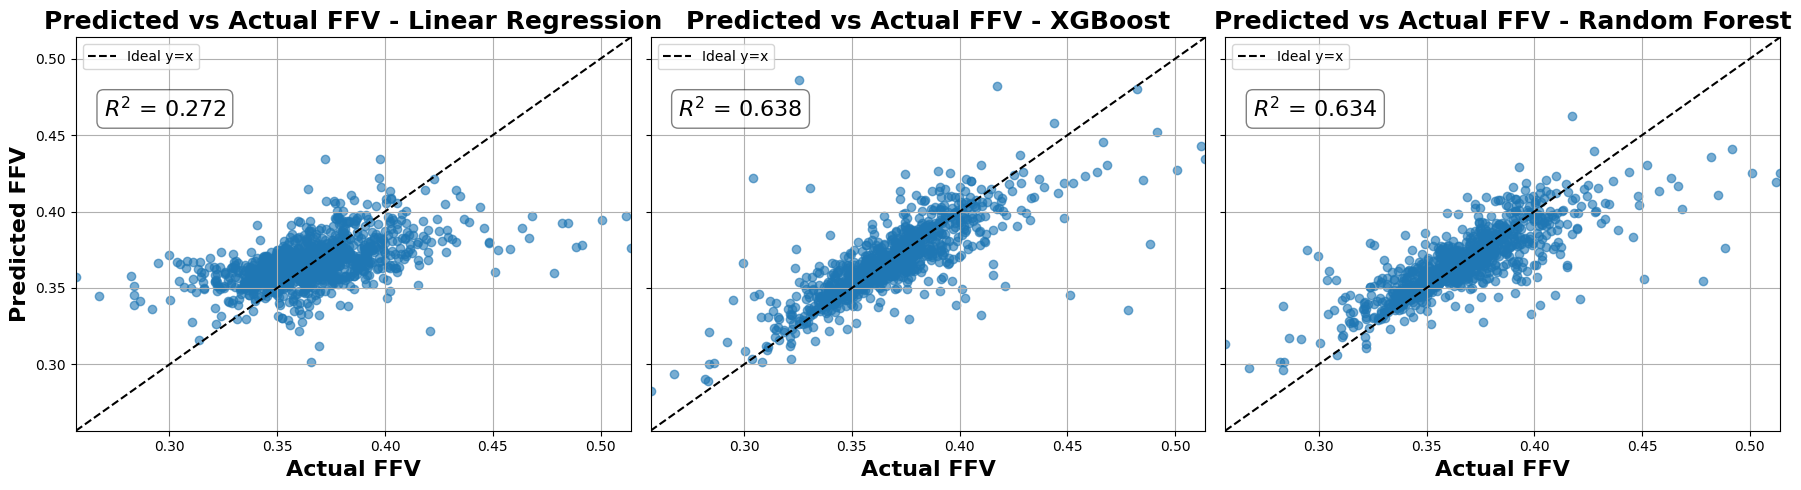

In [61]:
# Plotting predicted FFV vs actual FFV for test set
y_true = y_test
predictions = {
    'Linear Regression': linear_regressor.predict(x_test),
    'XGBoost': final_bst.predict(dtest) , 
    'Random Forest': rf.predict(x_test)
}
# Shared axis limits (ensures identical scale in all 3 plots)
ffv_min = min(y_true.min(), min([p.min() for p in predictions.values()]))
ffv_max = max(y_true.max(), max([p.max() for p in predictions.values()]))

# Parity plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (model_name, y_pred) in zip(axes, predictions.items()):
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6)
    r2 = r2_score(y_true, y_pred)
    ax.text(0.05, 0.85, f'$R^2$ = {r2:.3f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=16, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    # Ideal line
    ax.plot([ffv_min, ffv_max], [ffv_min, ffv_max], 'k--', label='Ideal y=x')

    # Labels and style
    ax.set_title(f'Predicted vs Actual FFV - {model_name}', fontsize=18, fontweight='bold')
    ax.set_xlabel("Actual FFV", fontsize=16, fontweight='bold')
    ax.set_ylim(ffv_min, ffv_max)
    ax.set_xlim(ffv_min, ffv_max)
    ax.grid(True)
    ax.legend()

# Only add y-label to first subplot (cleaner layout)
axes[0].set_ylabel("Predicted FFV", fontsize=16, fontweight='bold')

plt.tight_layout()
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/predicted_vs_actual_ffv_test_set.png', dpi=600)
plt.show()


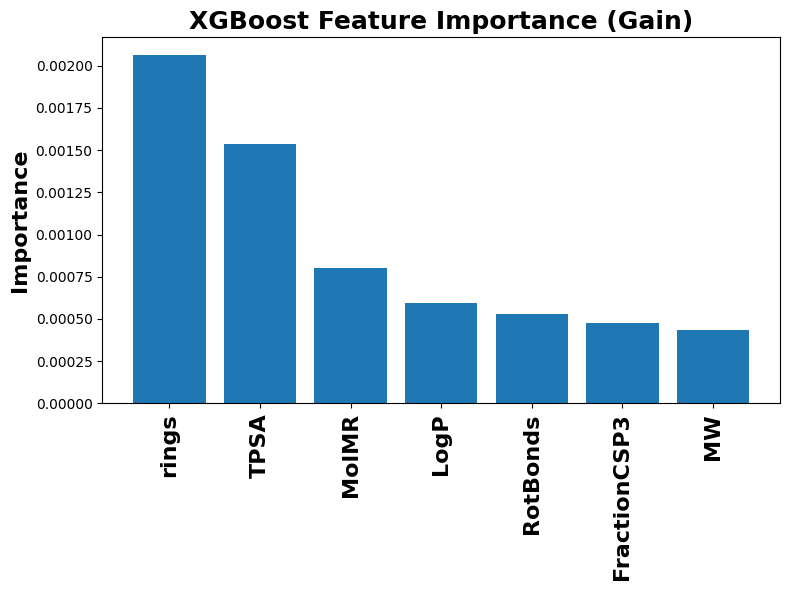

In [64]:
# Feature Importance from XGBoost model
# Get XGBoost gain importance
importance_dict = final_bst.get_score(importance_type='gain')
# Convert dictionary to arrays
features_xgb = np.array(list(importance_dict.keys()))
importances_xgb = np.array(list(importance_dict.values()))
# Sort in descending order
indices_xgb = np.argsort(importances_xgb)[::-1]
features_xgb = features_xgb[indices_xgb]
importances_xgb = importances_xgb[indices_xgb]
# Plot feature importance
plt.figure(figsize=(8,6))
plt.bar(range(len(importances_xgb)), importances_xgb)

plt.xticks(
    range(len(importances_xgb)),
    features_xgb,
    rotation=90,
    fontsize=16,
    fontweight='bold'
)

plt.title("XGBoost Feature Importance (Gain)", fontsize=18, fontweight='bold')
plt.ylabel("Importance", fontsize=16, fontweight='bold')

plt.tight_layout()
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/importance_features_XGBoost_matched.png', dpi=600)
plt.show()


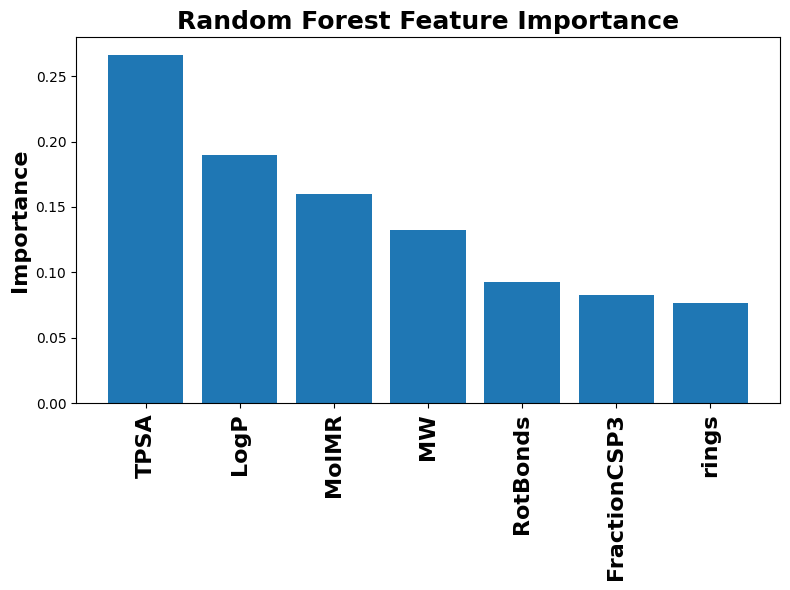

In [58]:
# Feature Importance from Random forest model
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = x.columns
 
plt.figure(figsize=(8,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90, fontsize=16, fontweight='bold')
plt.title("Random Forest Feature Importance", fontsize=18, fontweight='bold')
plt.ylabel("Importance", fontsize=16, fontweight='bold')
plt.tight_layout()
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/importance_features_RF.png', dpi=600)
plt.show()

In [56]:
# Permutation Importance for Random Forest 
perm_result = permutation_importance(
    rf,
    x_validation,
    y_validation,
    n_repeats=10,
    random_state=RANDOM_SEED,
    scoring="neg_mean_squared_error"
)
perm_importances = perm_result.importances_mean
perm_std = perm_result.importances_std
 
# Display nicely
for feature, importance, std in sorted(
    zip(descriptor_features, perm_importances, perm_std),
    key=lambda x: x[1],
    reverse=True
):
    print(f"{feature}: {importance:.4f} ± {std:.4f}")

TPSA: 0.0006 ± 0.0000
MolMR: 0.0003 ± 0.0000
LogP: 0.0002 ± 0.0000
RotBonds: 0.0002 ± 0.0000
rings: 0.0001 ± 0.0000
MW: 0.0001 ± 0.0000
FractionCSP3: 0.0001 ± 0.0000
